In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from binarypredictor import BinaryPredictor
from binarypredictor.dataset import FunctionPairDataset
from binarypredictor.net import DerivativeNet, TangentNet
from binarypredictor.cm import base_function, first_derivative, second_derivative

In [2]:
bp = BinaryPredictor(net_1='net_1m.pth', net_2='net_2.pth')

# AuAg

net_1.pth \
net_2.pth

In [3]:
R = 8.3143

gf = lambda t: 3815.93 + 109.3029 * t - 1.044523e-20 * t ** 7 - (-7209.5 + 118.2007 * t)
gg = lambda t: -3352 + 215.88 * t - 3.5899325e-21 * t ** 7 - (-15745 + 225.14 * t)

real_data = pd.read_csv('auag.txt', delimiter='\t')
t_range = real_data['LIQUID + FCC_A1']

f = lambda x, t: (1 - x) * gf(t) + x * gg(t) + R * t * ((1 - x) * torch.log(1 - x) + x * torch.log(x)) + (1 - x) * x * (-16402 + 1.14 * t)
g = lambda x, t: R * t * ((1 - x) * torch.log(1 - x) + x * torch.log(x)) + (1 - x) * x * (-15599)

df = lambda x, t: -16402 - gf(t) + gg(t) + 1.14 * t + 32804 * x - 2.28 * t * x - R * t * torch.log(1 - x) + R * t * torch.log(x)
dg = lambda x, t: 15599 * (-1 + 2 * x) - R * t * torch.log(1 - x) + R * t * torch.log(x)

xf_eq, xg_eq, ts = bp.get_phase_diagram(t_range, f, g, df, dg, k=1)

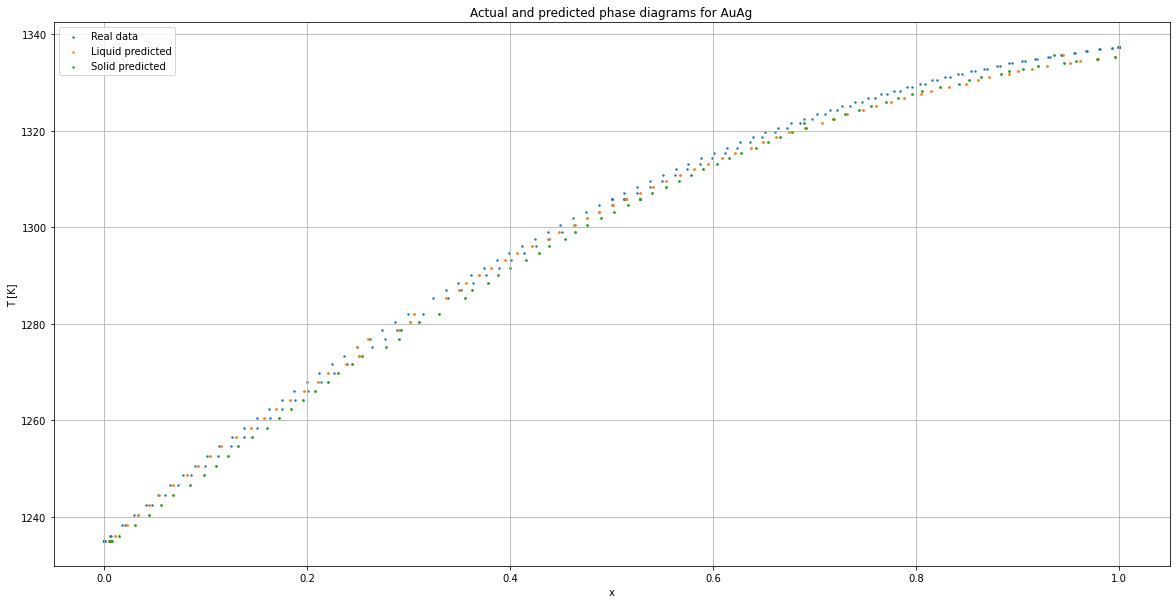

In [4]:
x_fs_ = []
for x_ in xf_eq: 
    x_fs_.append(x_[0])
    
x_gs_ = []
for x_ in xg_eq: 
    x_gs_.append(x_[0])
    
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
s = 2
ax.scatter(real_data['Mole fraction Au'], real_data['LIQUID + FCC_A1'], s=s, label='Real data')
ax.scatter(x_fs_, ts, s=s, label='Liquid predicted')
ax.scatter(x_gs_, ts, s=s, label='Solid predicted')
ax.grid()
plt.xlabel('x')
plt.ylabel('T [K]')
plt.title('Actual and predicted phase diagrams for AuAg')
ax.legend()

In [5]:
r_x = []

for x_, r_t in zip(real_data['Mole fraction Au'], real_data['LIQUID + FCC_A1']):
    if r_t in ts:
        r_x.append(x_)
        
x_fs_t = torch.tensor(x_fs_)
r_x_t = torch.tensor(r_x)

print('Mean error: ', nn.L1Loss()(x_fs_t, r_x_t).item())
print('Mean squared error: ', nn.MSELoss()(x_fs_t, r_x_t).item())
print('Max deviation: ' , torch.max(abs(x_fs_t - r_x_t)).item())
print('Min deviation: ' , torch.min(abs(x_fs_t - r_x_t)).item())

Mean error:  0.015658574178814888
Mean squared error:  0.0005111192003823817
Max deviation:  0.06623721122741699
Min deviation:  0.0001271665096282959


# Lukas-Petzow-Mager functions

In [188]:
@torch.no_grad()
def predict(t, net_1, net_2, f, g, df, dg, scale=1., plot=False, acc=4, threshold=0.3, max_threshold=0.6):
    """
    Predicts the equilibrium compositions of a binary system
    
    Parameters
    ----------
    net_1 : TangentNet
        network to predict equation 1
    net_2 : TangentNet 
        network to predict equation 2
    f : callable
        function for f
    g : callable
        function for g 
    df : torch.tensor
        first derivative values of f at x
    dg : torch.tensor
        first derivative values of g at x
    scale : float
        scaling factor so that the maximum function value is 1
    plot : bool
        whether to plot the results
    acc : int
        accuracy of output values (number of decimals)
    threshold : float
        threshold for the deviation from the tangent's slope and the functions' slopes
    max_threshold : float
        maximum threshold to which the threshold can be increased of no tangent is found 
    """    
    net_1.eval(), net_2.eval()
    
    # Network input
    f_, g_ = f(x, t)/scale, g(x, t)/scale
    inp = torch.hstack((f_, g_))
    
    # Network outputs
    out_1 = net_1(inp)
    out_2 = net_2(inp)
                
    # Get the equilibrium compositions by calculating the points of intersections (by approximating as the intersection
    # of the lines connecting the values of out_1 and out_2 at sign changes)
    out_diff = out_1 - out_2
    idx = torch.where(abs(out_diff) < 0.1)[0][:-1]
        
    if len(idx) == 0:
        return torch.tensor([]), torch.tensor([])
    
    x_f = torch.hstack((out_1[idx], out_2[idx], out_1[idx + 1], out_2[idx + 1], 
                        (out_1[idx] + out_2[idx])/2, (out_1[idx + 1] + out_2[idx + 1])/2))
    x_g = torch.hstack((x[idx], x[idx], x[idx + 1], x[idx + 1], x[idx], x[idx + 1]))
    
    # Get the function values at the equilibria
    y_f, y_g = f(x_f, t)/scale, g(x_g, t)/scale
            
    # Get the slopes of the lines between the equilibria points
    slopes = (y_g - y_f)/(x_g - x_f)
        
    # Remove lines that are not tangents
    slope_cond = (abs(slopes - dg(x_g, t)/scale) <= threshold) & (abs(slopes - df(x_f, t)/scale) <= threshold)
    idx = torch.where(slope_cond)[0]
    
    while len(idx) == 0 and threshold <= max_threshold:
        threshold += 0.1
        slope_cond = (abs(slopes - dg(x_g, t)/scale) <= threshold) & (abs(slopes - df(x_f, t)/scale) <= threshold)
        idx = torch.where(slope_cond)[0]
    
    # Recalculate x and y values for all points that are tangent points
    x_f, x_g = x_f[idx], x_g[idx]
    slope_dist = torch.sqrt((slopes[idx] - dg(x_g, t)/scale) ** 2 + (slopes[idx] - df(x_f, t)/scale) ** 2)
    
    f_floor = (torch.floor(x_f * 10)/10).unsqueeze(-1)
    g_floor = (torch.floor(x_g * 10)/10).unsqueeze(-1)
    f_g_slope = np.hstack((f_floor, g_floor, slope_dist.unsqueeze(-1)))
    
    dataframe = pd.DataFrame(f_g_slope)
    mins = dataframe.groupby([0, 1]).idxmin()
    
    x_f = x_f[np.array(mins).reshape(-1, )]
    x_g = x_g[np.array(mins).reshape(-1, )]
    
    y_f, y_g = f(x_f, t)/scale, g(x_g, t)/scale
    
    slopes = (y_g - y_f)/(x_g - x_f)
    
    # Only take the k best tangents to save time
    slope_dist = torch.sqrt((slopes - dg(x_g, t)/scale) ** 2 + (slopes - df(x_f, t)/scale) ** 2)
    
    # Choose the best tangent if there are multiple results for the same tangent
    if len(x_f) > 1:
        x_eqs = torch.tensor(list(zip(x_f, x_g)))
        s_idx = torch.where(abs(torch.cdist(x_eqs, x_eqs)) < 0.2)
        
        left, right = s_idx[0], s_idx[1]
        left_unique = torch.unique(left)
                
        cis = []
        for i in left_unique:
            idx = torch.where(left == i)[0]
            add = right[idx]
            if len(add) > 0:
                cis.append(add[torch.argmin(slope_dist[add])]) 
            else:
                continue
            right = torch.tensor([r for r in right if r not in add])
            left = torch.tensor([l for l in left if l not in add]) 
            
        cis = torch.tensor(cis)
            
        x_f, x_g = x_f[cis], x_g[cis]
        y_f, y_g = f(x_f, t)/scale, g(x_g, t)/scale
    
    # Plot the outputs
    if plot:
        plt.scatter(x, out_1.detach(), s=0.2)
        plt.scatter(x, out_2.detach(), s=0.2)
        plt.title('Network outputs')
        plt.xlabel('x\'\'')
        plt.ylabel('x\'')
        plt.grid()
        plt.show()

        plt.scatter(x, out_diff.detach(), s=0.2)
        plt.title('Difference between network outputs')
        plt.xlabel('x\'\'')
        plt.ylabel('Difference')
        plt.grid()
        plt.show()
        
        print('x\'_eq: ', np.round(x_f.tolist(), decimals=acc))
        print('x\'\'_eq: ', np.round(x_g.tolist(), decimals=acc))
        
        for x_f_eq, x_g_eq, y_f_eq, y_g_eq in zip(x_f, x_g, y_f, y_g):
            plt.plot([x_f_eq, x_g_eq], [y_f_eq, y_g_eq], 'ro-')
            plt.plot(x, f_)
            plt.plot(x, g_)
            plt.show()
            
    return x_f, x_g

In [8]:
def a(a_sum, a_diff, TM):
    r = 8.314

    a_sum *= TM * r
    a_diff *= TM * r

    a_1 = (a_sum - a_diff) / 2
    a_2 = (a_sum + a_diff) / 2

    return a_1, a_2

In [232]:
x = torch.arange(1e-10, 1., step=1/500)

tm_1, tm_2 = 900, 1100
tm = (tm_1 + tm_2)/2

a_diff = -1
a_sum = 0
a_1, a_2 = a(a_sum, a_diff, tm)
print(a_1, a_2)

k = dict()
k['step'] = 1/500
k['tm1'] = tm_1
k['tm2'] = tm_2
k['tm'] = tm
k['s1'] = 10
k['s2'] = 10
k['a'] = a_1

c = dict()
c['step'] = 1/500
c['tm1'] = tm_1
c['tm2'] = tm_2
c['tm'] = tm
c['s1'] = 0
c['s2'] = 0
c['a'] = a_2

4157.0 -4157.0


In [237]:
x = torch.arange(1e-10, 1., step=1/500)
t_range = range(600, 1500)

xf_eq, xg_eq, ts = [], [], []

net_1 = torch.load('net_1.pth')
net_2 = torch.load('net_2.pth')

for t in t_range:
    #print(t)
    f = lambda x, t: base_function(**k, x=x, t=t)
    g = lambda x, t: base_function(**c, x=x, t=t)

    df = lambda x, t: first_derivative(**k, x=x, t=t)
    dg = lambda x, t: first_derivative(**c, x=x, t=t)

    # Skip the prediction if there are no intersections because then there can't be any common tangents
    diff = f(x, t) - g(x, t)
    if (len(diff[diff > 0]) == len(f(x, t))) or (len(diff[diff > 0]) == 0):
        continue

    scale = max(torch.max(abs(f(x, t))), torch.max(abs(g(x, t))))

    x_f_, x_g_ = predict(t, net_1, net_2, f, g, df, dg, scale=scale, threshold=0.3, plot=False)
    
    xf_eq.append(x_f_)
    xg_eq.append(x_g_)
    ts.append(t)

In [ ]:
t_range = range(1000, 1015)

f = lambda x, t: base_function(**k, x=x, t=t)
g = lambda x, t: base_function(**c, x=x, t=t)

df = lambda x, t: first_derivative(**k, x=x, t=t)
dg = lambda x, t: first_derivative(**c, x=x, t=t)

xf_eq, xg_eq, ts = bp.get_phase_diagram(t_range, f, g, df, dg, plot=True, threshold=.5, k=5)

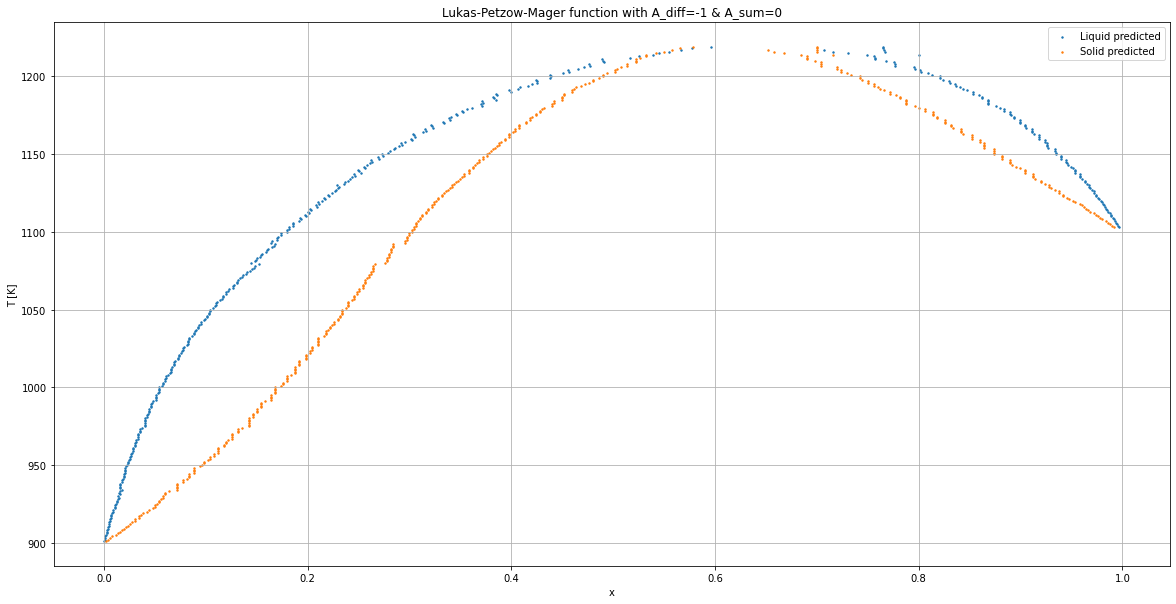

In [238]:
x_fs_ = []
x_gs_ = []
ts_ = []
for i, xs in enumerate(zip(xf_eq, xg_eq)): 
    for xf_, xg_ in zip(xs[0], xs[1]):
        x_fs_.append(xf_)
        x_gs_.append(xg_)
        ts_.append(ts[i])
            
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
s = 2
ax.scatter(x_fs_, ts_, s=s, label='Liquid predicted')
ax.scatter(x_gs_, ts_, s=s, label='Solid predicted')
plt.xlabel('x')
plt.ylabel('T [K]')
plt.title('Lukas-Petzow-Mager function with A_diff=-1 & A_sum=0')
plt.grid()
ax.legend()

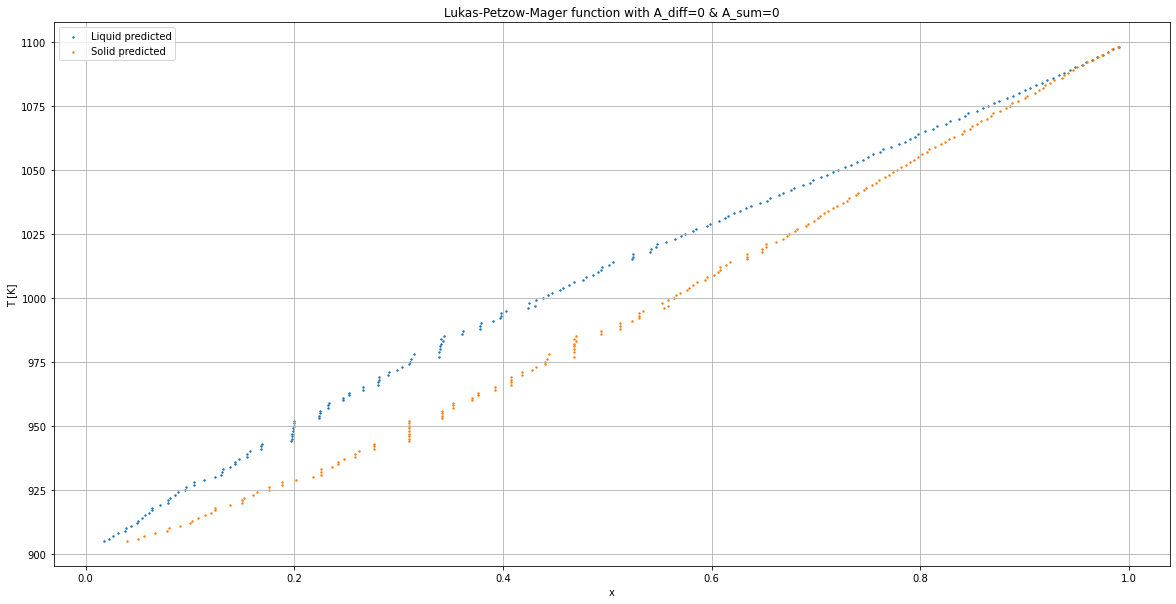

In [164]:
x_fs_ = []
x_gs_ = []
ts_ = []
for i, xs in enumerate(zip(xf_eq, xg_eq)): 
    for xf_, xg_ in zip(xs[0], xs[1]):
        x_fs_.append(xf_)
        x_gs_.append(xg_)
        ts_.append(ts[i])
            
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
s = 2
ax.scatter(x_fs_, ts_, s=s, label='Liquid predicted')
ax.scatter(x_gs_, ts_, s=s, label='Solid predicted')
plt.xlabel('x')
plt.ylabel('T [K]')
plt.title('Lukas-Petzow-Mager function with A_diff=0 & A_sum=0')
plt.grid()
ax.legend()